### Installing required libraries

In [1]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

Importing libraries

In [2]:
import numpy as np
import pandas as pd
#import pytorch_lightning as pl
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP,VanillaTransformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss,MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Create calculate error metrics function which helps in assessing the performance of the trained model

In [3]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set

In [4]:
from neuralforecast.utils import AirPassengersDF as Y_df

Split data into **train** and **test**

In [6]:

# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


Lets initialize and training model (**VanillaTransformer**) and define its hyperparameters.

In [7]:
horizon = 12
model = VanillaTransformer(h=horizon,
                 input_size=12,
                 hidden_size=16,
                 conv_hidden_size=32,
                 n_head=2,
                 loss=MAE(),
                 #futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [8]:
nf.fit(df=Y_train_df, val_size=12)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 48     | train
4 | dec_embedding | DataEmbedding | 48     | train
5 | encoder       | TransEncoder  | 4.5 K  | train
6 | decoder       | TransDecoder  | 3.4 K  | train
--------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predict for the next defined horizon

In [9]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [10]:
forecasts

,ds,VanillaTransformer
unique_id,,
1.0,1960-01-31,399.015778
1.0,1960-02-29,419.278839
1.0,1960-03-31,446.802612
1.0,1960-04-30,446.806213
1.0,1960-05-31,449.698669
1.0,1960-06-30,549.017456
1.0,1960-07-31,628.421692
1.0,1960-08-31,646.206665
1.0,1960-09-30,557.690063


Measure the models accuracy

In [11]:
calculate_error_metrics(Y_test_df[['y']],forecasts['VanillaTransformer'])

MSE : 688.7931518554688
RMSE : 26.244869232177734
MAPE : 0.04862939938902855
r2 : 0.8756572681442947
adjusted_r2 : 0.8632229949587241


Visualize the predictions

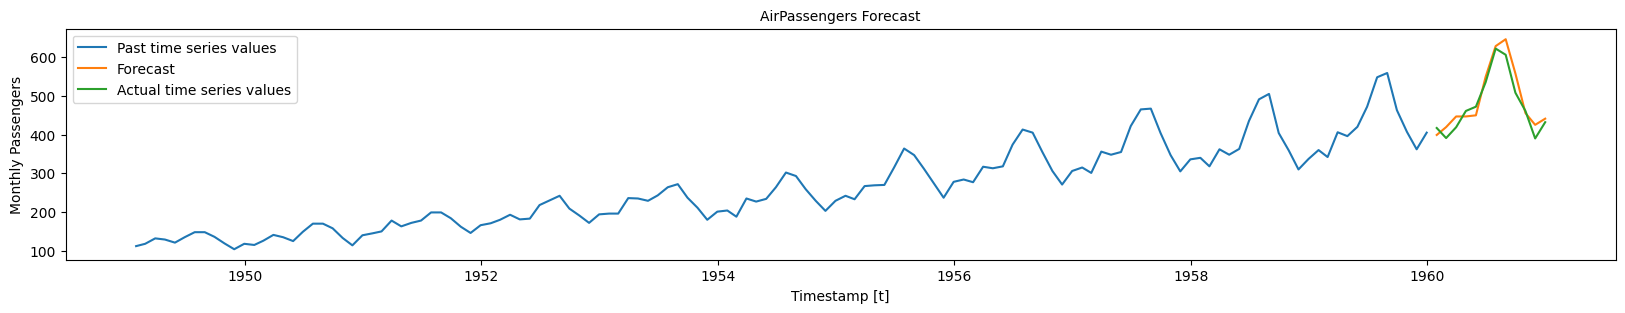

In [12]:
Y_train_df.set_index('ds',inplace =True)
forecasts.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = Y_train_df["y"]
y_pred = forecasts['VanillaTransformer']
y_test = Y_test_df["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(forecasts, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();